# Evaluation - Echo Chamber

## Local Code Imports

In [117]:
from src import model as mdl
from src import custom as cm

## Code Imports

In [2]:
import pandas as pd
import numpy as np
from joblib import load
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

# Data

## Import Data Files

In [3]:
user_fac = pd.read_csv('../data/processed/user_factors.csv', index_col='id')

In [5]:
item_fac = pd.read_csv(
    '../data/processed/item_factors_unstacked.csv', index_col='id')

## Build Rankings Matrix

In [8]:
ALS_rankings_matrix = user_fac.to_numpy().dot(item_fac.T.to_numpy())

In [9]:
ALS_rankings_matrix.shape

(243658, 28755)

## Sample Users

In [10]:
idx = np.random.randint(0, 243658, size=1000)

In [11]:
sample_user_facs = user_fac.to_numpy()[idx, :]

In [12]:
sample = ALS_rankings_matrix[idx, :]

In [13]:
sample_df = pd.DataFrame(sample)

In [15]:
sample_df.columns = item_fac.index

In [17]:
sample_T = sample_df.T

In [19]:
sample_T.reset_index(inplace=True)

## Filter for Most Rated Movies

In [21]:
most_rated = pd.read_csv(
    '../data/processed/most_rated.csv', index_col='Unnamed: 0')

In [22]:
most_rated

,movieId,title,genres
0,171011,Planet Earth II (2016),Documentary
1,159817,Planet Earth (2006),Documentary
2,318,"Shawshank Redemption, The (1994)",Crime|Drama
3,170705,Band of Brothers (2001),Action|Drama|War
4,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller
5,171495,Cosmos,(no genres listed)
6,172591,The Godfather Trilogy: 1972-1990 (1992),(no genres listed)
7,858,"Godfather, The (1972)",Crime|Drama
8,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
9,1221,"Godfather: Part II, The (1974)",Crime|Drama


In [23]:
sample_redx = pd.merge(sample_T, most_rated, how='inner',
                       left_on='id', right_on='movieId')

In [24]:
sample_redx.set_index('id', inplace=True)

In [25]:
sample_redx.drop(['movieId', 'title', 'genres'], axis=1, inplace=True)

# Get ALS Top 100 for Sample

In [26]:
als_top_100s = []
for idx, col in enumerate(sample_redx):
    top_100 = sample_redx[col].sort_values(ascending=False).head(100)
    top_100_df = pd.DataFrame(top_100)
    top_100_df.reset_index(inplace=True)
    als_top_100s.append(top_100_df)

# Get Cluster Top 100 for Sample

## Predict Users' Clusters

In [27]:
gbc = load('../models/fifp_classification.joblib')

In [28]:
preds = gbc.predict(sample_user_facs)

## Get Cluster Centroid Ratings

In [29]:
centroids = pd.read_csv(
    '../data/processed/centroids.csv', index_col='Unnamed: 0')
centroid_ratings_T_df = cm.get_centroid_ratings(centroids, item_fac)

In [30]:
centroid_ratings_T_df.reset_index(inplace=True)

In [31]:
centroid_ratings_redx = pd.merge(
    centroid_ratings_T_df, most_rated, how='inner', left_on='id', right_on='movieId')

In [32]:
centroid_ratings_redx.set_index('id', inplace=True)

In [33]:
centroid_ratings_redx.drop(
    ['movieId', 'title', 'genres'], axis=1, inplace=True)

## Get Cluster Top 100

In [36]:
cluster_top_100s = []
for cluster in preds:
    top_100 = centroid_ratings_redx[cluster].sort_values(
        ascending=False).head(100)
    top_100_df = pd.DataFrame(top_100)
    top_100_df.reset_index(inplace=True)
    cluster_top_100s.append(top_100_df)

# Evaluation: Proportion of Top 100 Movies Shared between the ALS recommendations and the User's Cluster Centroid

In [37]:
proportions = []
for i in range(len(cluster_top_100s)):
    als_set = set(als_top_100s[i].iloc[:, 0])
    cluster_set = set(cluster_top_100s[i].iloc[:, 0])
    intersection = als_set.intersection(cluster_set)
    n_in_common = len(intersection)
    proportion_in_common = (n_in_common/100)
    proportions.append(proportion_in_common)

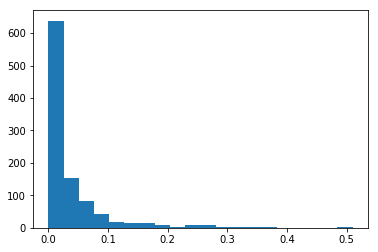

In [38]:
plt.hist(proportions, bins=20)

# Evaluation: Proportion of Top 100 Movies Shared between the ALS and Augmented Recommendations

In [39]:
cluster_distances = pd.read_csv(
    '../data/processed/cluster_distances_df.csv', index_col='Unnamed: 0')

In [40]:
cluster_distances.head()

,0,1,2,3,4,5,6,7,8
0,0.000000,8.798096,9.716017,7.041225,6.007564,10.984834,5.646137,6.316699,6.183063
1,8.798096,0.000000,5.956857,6.540400,8.858469,4.575128,4.660669,4.302251,4.401584
2,9.716017,5.956857,0.000000,7.768660,6.161390,9.719417,5.783137,8.817718,5.600428
3,7.041225,6.540400,7.768660,0.000000,8.586475,7.407208,6.431559,6.280426,6.763831
4,6.007564,8.858469,6.161390,8.586475,0.000000,12.469241,6.062674,8.974924,5.407681


In [41]:
cm.get_nearest_clusters(cluster_distances, '8')

array([6, 1])

In [42]:
proportions = []
for i in range(len(cluster_top_100s)):
    j = preds[i]
    nearest_clusters = cm.get_nearest_clusters(
        cluster_distances, '{}'.format(j))
    cluster1 = nearest_clusters[0]
    cluster2 = nearest_clusters[1]
    als_set = set(als_top_100s[i].iloc[:, 0])
    cluster1_set = set(cluster_top_100s[cluster1].iloc[:, 0])
    cluster2_set = set(cluster_top_100s[cluster2].iloc[:, 0])
    cluster_full = cluster1_set.union(cluster2_set)
    intersection = als_set.intersection(cluster_full)
    n_in_common = len(intersection)
    proportion_in_common = (n_in_common/100)
    proportions.append(proportion_in_common)

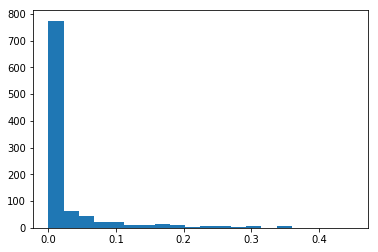

In [43]:
plt.hist(proportions, bins=20)

# Evaluation: Distances Between ALS Recommended Movies and Nearest Cluster Recommended Movies

        - Calculate a distance matrix for the movies
        - Compare the distances between the movies in the ALS recommendation and the movies in the augmented recommendation (between group variation)
            - Shows that the within group distances are small, and
            - Shows that the between group distances are larger


In [44]:
movie_distances = cm.get_cluster_distances(item_fac)

In [75]:
movie_distances.columns = item_fac.index

In [77]:
movie_distances.index = item_fac.index

In [86]:
movie_distances.head()

id,1,2,3,4,5,6,7,8,9,10,...,192431,192491,192551,192559,192579,192697,192777,192849,193185,193243
id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.659943,0.794709,0.912989,0.884246,0.641788,0.677227,0.910320,1.059156,0.593580,...,1.741641,1.167652,0.901712,0.925019,1.360799,0.930302,1.148112,1.063131,2.075248,1.072819
2,0.659943,0.000000,0.261255,0.501278,0.393101,0.806566,0.417505,0.320245,0.460419,0.363693,...,1.626498,1.065402,0.552738,0.540987,0.929445,0.941761,1.096010,1.400469,2.142091,1.152650
3,0.794709,0.261255,0.000000,0.514890,0.277194,0.923487,0.480939,0.337013,0.388294,0.495208,...,1.686322,1.107492,0.705466,0.532303,0.926745,1.044446,1.137636,1.529964,2.237847,1.269069
4,0.912989,0.501278,0.514890,0.000000,0.390038,1.077467,0.434188,0.360389,0.698028,0.794689,...,1.295143,0.830129,0.848943,0.607086,1.172898,1.032247,0.863496,1.461704,2.209252,1.151558
5,0.884246,0.393101,0.277194,0.390038,0.000000,1.105320,0.379351,0.266087,0.558770,0.700429,...,1.483250,1.063782,0.848526,0.453636,1.120805,1.183639,1.111560,1.644614,2.377836,1.156615


In [120]:
nearest_clusters_top = []
for i in range(len(cluster_top_100s)):
    j = preds[i]
    nearest_clusters = cm.get_nearest_clusters(
        cluster_distances, '{}'.format(j))
    cluster1 = nearest_clusters[0]
    cluster2 = nearest_clusters[1]
    cluster1_set = set(cluster_top_100s[cluster1].iloc[:, 0])
    cluster2_set = set(cluster_top_100s[cluster2].iloc[:, 0])
    cluster_full_set = cluster1_set.union(cluster2_set)
    cluster_full_list = list(cluster_full_set)
    nearest_clusters_top.append(cluster_full_list)

In [114]:
MSS_distances_within = []
for i in range(len(als_top_100s)):
    within_distances = []
    for j in als_top_100s[i].iloc[:, 0]:
        for k in als_top_100s[i].iloc[:, 0]:
            if j == k:
                pass
            else:
                within_distances.append(movie_distances[j][k])
    sq_within_distances = [x**2 for x in within_distances]
    MSS_distances = np.mean(sq_within_distances)
    MSS_distances_within.append(MSS_distances)

In [127]:
MSS_distances_between = []
for i in range(len(als_top_100s)):
    between_distances = []
    for j in als_top_100s[i].iloc[:, 0]:
        for k in nearest_clusters_top[i]:
            between_distances.append(movie_distances[j][k])
    sq_between_distances = [x**2 for x in between_distances]
    MSS_distances = np.mean(sq_between_distances)
    MSS_distances_between.append(MSS_distances)

In [128]:
stats.ttest_ind(MSS_distances_within, MSS_distances_between, equal_var=False)

Ttest_indResult(statistic=-66.19551095638982, pvalue=0.0)

# Evaluation: Difference in Distances Between ALS Recommended Movies and Nearest Cluster Recommended Movies and the Distances Between ALS Recommended Movies and Furthest Cluster Recommended Movies

        - Compare the distances between the ALS and augmented recommendations to the distances between the ALS and most distant movies.
            - Shows that augmented recommendations are closer to ALS recommendations than the most distant movies



In [118]:
def get_furthest_clusters(cluster_distance_df, cluster):
    """Returns the ID of the two clusters furthest from the specified cluster.
    Parameters
    ----------
    cluster_distance_df : dataframe
        A dataframe containing the distances between
        each pair of clusters.
    cluster: integer
        An integer indicating the ID of the cluster for which
        the nearest clusters are being identified."""
    sorted_distances = cluster_distance_df[cluster].sort_values(
        ascending=False)
    two_nearest_clusters = sorted_distances[0:2].index.values.astype(int)
    return two_nearest_clusters

In [129]:
furthest_clusters_top = []
for i in range(len(cluster_top_100s)):
    j = preds[i]
    nearest_clusters = get_furthest_clusters(cluster_distances, '{}'.format(j))
    cluster1 = nearest_clusters[0]
    cluster2 = nearest_clusters[1]
    cluster1_set = set(cluster_top_100s[cluster1].iloc[:, 0])
    cluster2_set = set(cluster_top_100s[cluster2].iloc[:, 0])
    cluster_full_set = cluster1_set.union(cluster2_set)
    cluster_full_list = list(cluster_full_set)
    furthest_clusters_top.append(cluster_full_list)

In [132]:
MSS_distances_between_furthest = []
for i in range(len(als_top_100s)):
    within_distances = []
    for j in als_top_100s[i].iloc[:, 0]:
        for k in furthest_clusters_top[i]:
            within_distances.append(movie_distances[j][k])
    sq_within_distances = [x**2 for x in within_distances]
    MSS_distances = np.mean(sq_within_distances)
    MSS_distances_between_furthest.append(MSS_distances)

In [139]:
within_between_differences = np.subtract(
    MSS_distances_between, MSS_distances_within)
within_furthest_differences = np.subtract(
    MSS_distances_between_furthest, MSS_distances_within)

In [140]:
stats.ttest_ind(within_between_differences,
                within_furthest_differences, equal_var=False)

Ttest_indResult(statistic=-5.516741793081464, pvalue=3.907336572476676e-08)

# Next Steps

Change from a system where recommendations are made by cluster centroid to an average rating system.